In [1]:
# This code is adapted from Kevin Mader @ [https://www.kaggle.com/kmader/dematology-mnist-csv-overview]

%matplotlib inline
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def guess_image_dim(in_shape):
    side_len = int(np.sqrt(in_shape))
    if np.abs(in_shape-side_len*side_len)<2:
        return (int(side_len), int(side_len))
    else:
        side_len = int(np.sqrt(in_shape/3))
        return (side_len, side_len, 3)
    
csv_dir = '/Users/leaf/SpringBoard/Capstone/download/MNIST'

In [2]:
all_files = sorted(glob(os.path.join(csv_dir, '*mnist*.csv')), 
                   key=lambda x: os.stat(x).st_size)[:5]  # change to [:5+n] to include n more files
all_df_dict = {os.path.splitext(os.path.basename(x))[0]: pd.read_csv(x) for x in all_files}
for c_key in all_df_dict.keys():
    print(c_key, 'vector length:',  all_df_dict[c_key].shape[1], '->', guess_image_dim(all_df_dict[c_key].shape[1]))

hmnist_8_8_L vector length: 65 -> (8, 8)
hmnist_8_8_RGB vector length: 193 -> (8, 8, 3)
hmnist_28_28_L vector length: 785 -> (28, 28)
hmnist_28_28_RGB vector length: 2353 -> (28, 28, 3)
hmnist_64_64_L vector length: 4097 -> (64, 64)


In [3]:
# A few utility functions for showing MNIST-style images easily
from skimage.util import montage
def show_data_as_images(in_df, sample=None, title='Group'):
    fig, m_axs = plt.subplots(2, 4, figsize = (20, 10))
    resize_dim = guess_image_dim(in_df.shape[1])
    for c_ax, (c_label, c_rows) in zip(m_axs.flatten(), 
                                       in_df.groupby(['label'])):
        c_images = c_rows.values[:, :-1].reshape((-1,)+resize_dim)
        if sample is None:
            md_args = {}
        else:
            md_args = {'grid_shape': (1, sample)}
            c_images = c_images[np.random.choice(range(c_images.shape[0]), sample)]
        if len(resize_dim)==2:
            c_montage = montage(c_images, **md_args)
            c_ax.matshow(c_montage, vmin=0, vmax=255, cmap='gray')
        elif len(resize_dim)==3:
            c_montage = np.stack([montage(c_images[:, :, :, i], **md_args) 
                                  for i in range(c_images.shape[3])],-1)
            c_ax.imshow(c_montage)
        
        c_ax.set_title('{}: {}'.format(title, c_label))
        c_ax.axis('off')

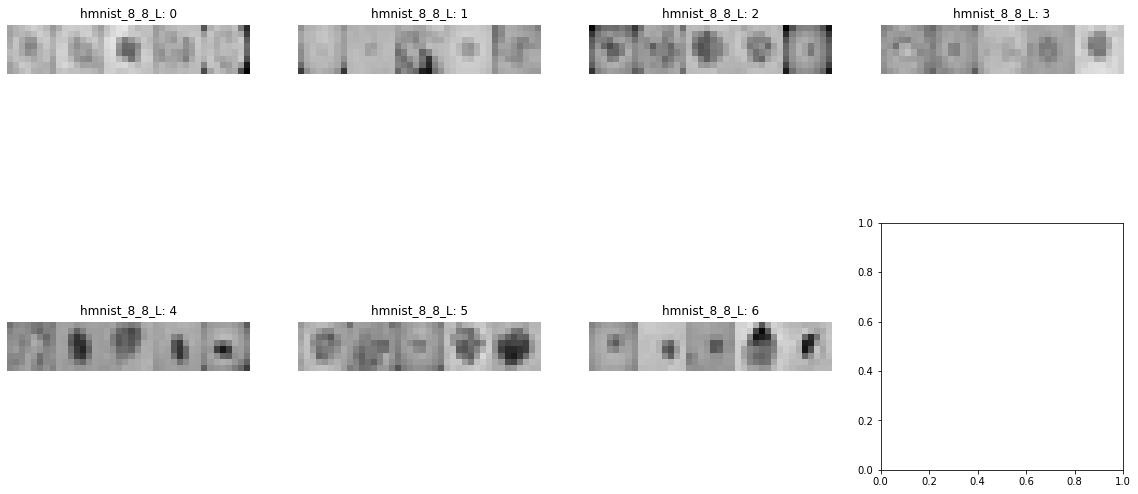

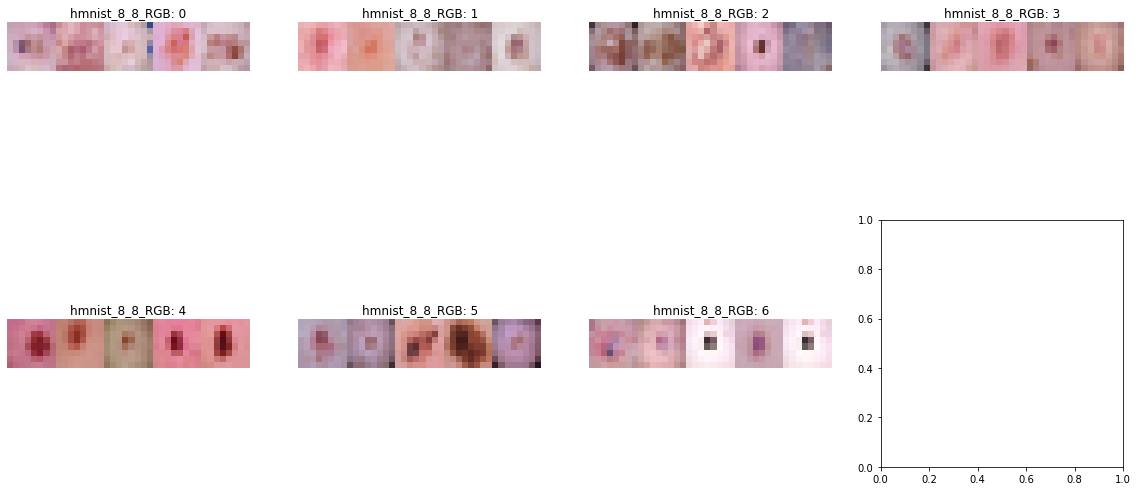

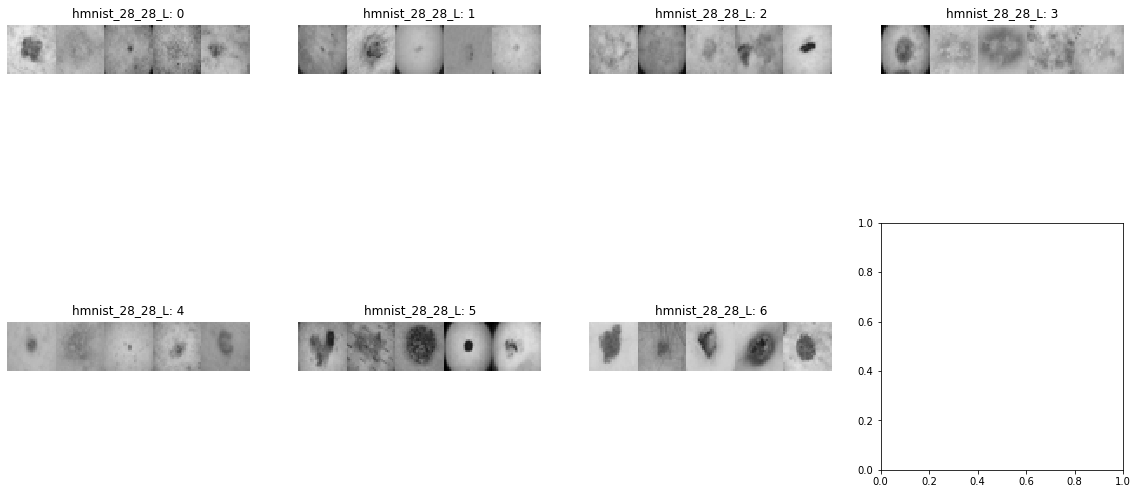

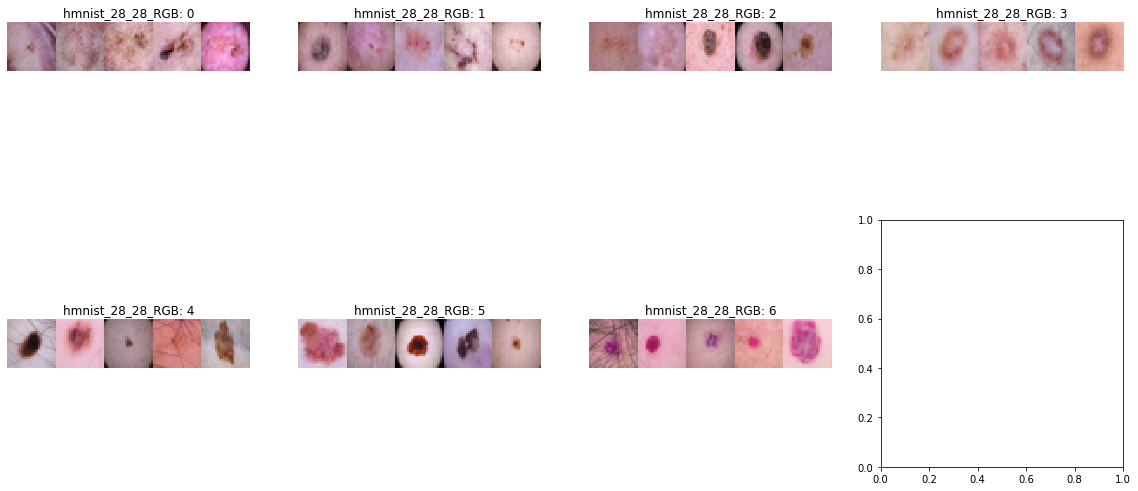

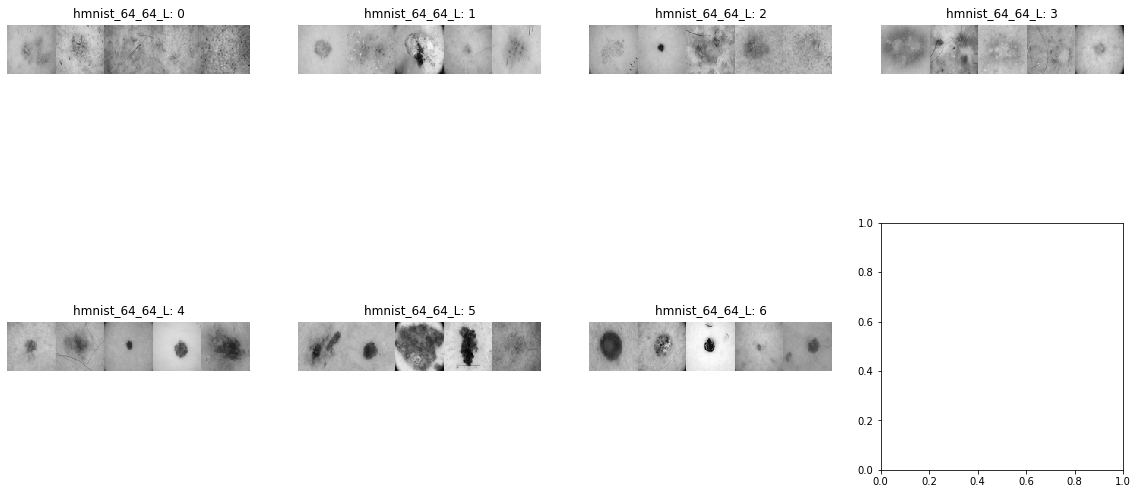

In [4]:
for c_key in all_df_dict.keys():
    show_data_as_images(all_df_dict[c_key], sample=5, title=c_key)

In [5]:
from sklearn.model_selection import train_test_split
sample_id_count = list(all_df_dict.values())[0].shape[0]
train_ids, test_ids = train_test_split(range(sample_id_count), 
                                       test_size=0.25, 
                                       random_state=2018)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_models(in_model_maker):
    fig, m_axs = plt.subplots(1, 5, figsize = (25, 5))
    for c_ax, c_key in zip(m_axs, all_df_dict.keys()):
        c_df = all_df_dict[c_key].copy()
        c_label = c_df.pop('label')
        c_model = in_model_maker()
        c_model.fit(c_df.iloc[train_ids, :], c_label.iloc[train_ids])
        c_pred = c_model.predict(c_df.iloc[test_ids, :])
        sns.heatmap(confusion_matrix(c_label.iloc[test_ids], c_pred), 
                    annot=True, cbar=False, fmt='d', ax=c_ax)
        c_ax.set_title(f'Accuracy: {accuracy_score(c_label[test_ids], c_pred)*100:2.2f}%\n{c_key}')

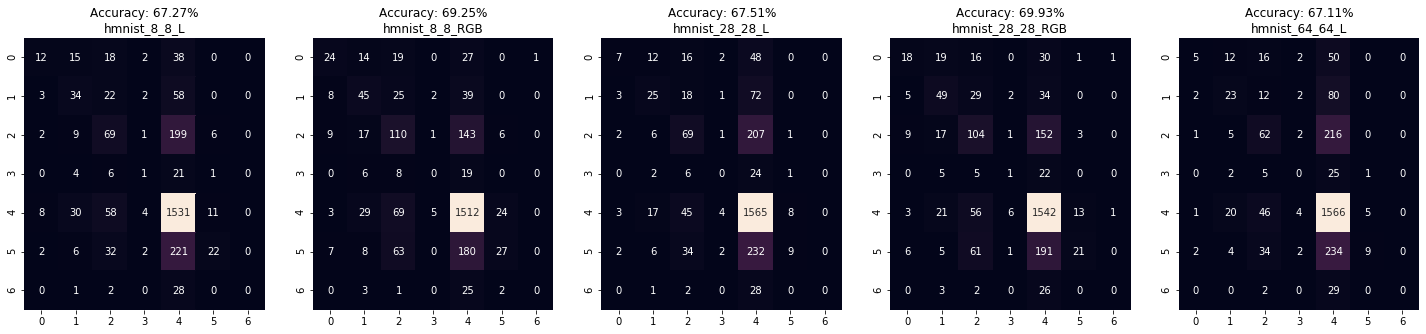

In [7]:
from sklearn.neighbors import KNeighborsClassifier
evaluate_models(lambda : KNeighborsClassifier(n_jobs=4))

In [8]:
import warnings
warnings.filterwarnings("ignore")

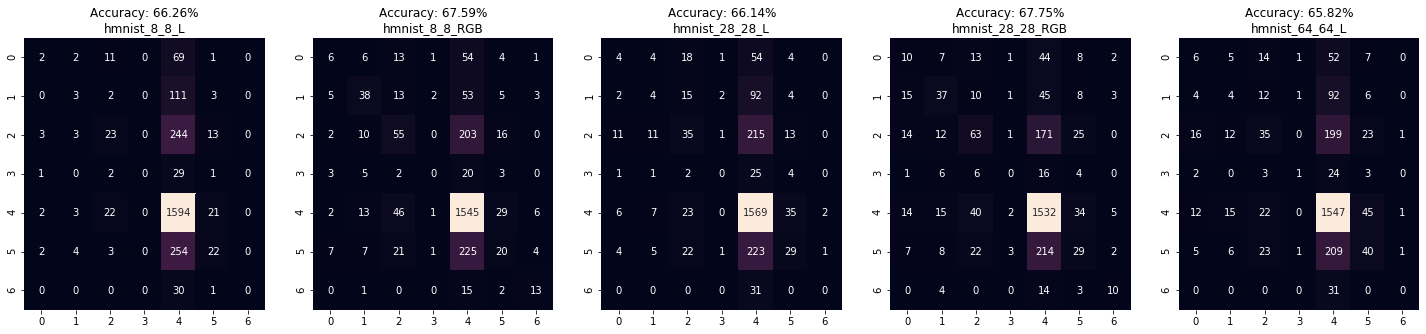

In [9]:
from sklearn.linear_model import LogisticRegression
evaluate_models(lambda : LogisticRegression(n_jobs=4, solver='lbfgs'))

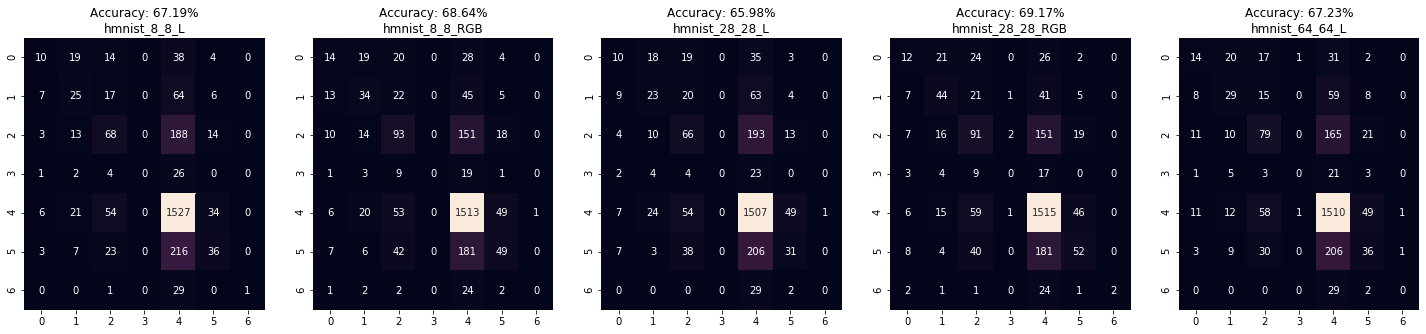

In [10]:
from sklearn.ensemble import RandomForestClassifier
evaluate_models(lambda : RandomForestClassifier(n_jobs=4))

In [13]:
from sklearn.metrics import classification_report

def evaluate_classifier(in_model_maker):
    for c_key in all_df_dict.keys():
        c_df = all_df_dict[c_key].copy()
        c_label = c_df.pop('label')
        c_model = in_model_maker()
        c_model.fit(c_df.iloc[train_ids, :], c_label.iloc[train_ids])
        c_pred = c_model.predict(c_df.iloc[test_ids, :])
        print(f'Classification Report for Random Forest Classifier trained on {c_key}\n',
              classification_report(c_label.iloc[test_ids], c_pred, 
             target_names = ['Actinic Keratosis', 'Basal Cell Carcinoma', 'Benign Keratosis-like Lesions',
                            'Dermatofibroma', 'Melanocytic Nevi', 'Vascular Lesions', 'Melanoma']))

In [14]:
evaluate_classifier(lambda : RandomForestClassifier(n_jobs=4))

Classification Report for Random Forest Classifier trained on hmnist_8_8_L
                                precision    recall  f1-score   support

            Actinic Keratosis       0.35      0.14      0.20        85
         Basal Cell Carcinoma       0.36      0.22      0.27       119
Benign Keratosis-like Lesions       0.34      0.22      0.26       286
               Dermatofibroma       0.00      0.00      0.00        33
             Melanocytic Nevi       0.72      0.93      0.81      1642
             Vascular Lesions       0.27      0.09      0.13       285
                     Melanoma       0.00      0.00      0.00        31

                     accuracy                           0.66      2481
                    macro avg       0.29      0.23      0.24      2481
                 weighted avg       0.58      0.66      0.60      2481

Classification Report for Random Forest Classifier trained on hmnist_8_8_RGB
                                precision    recall  f1-score  